# Replicability and transparency in topic modelling: developing best practice guidelines for the digital humanities

_Copyright (c) 2023 [Andressa Gomide, Mathew Gillings, Diego Gimenez]_

This file is part of Gomide et al. 2023.

This project is licensed under the terms of the MIT license.

This Jupyter Notebook is divided in three sections: (i) data collection and cleaning; (ii) tokenization, tagging and cleaning; and (iii) applying TM.
Each section represents one file in the folder [link]

1. **Data collection and cleaning**

*@get_gutemberg.py*

The codes in this section are used to download books from the Gutemberg Project (https://www.gutenberg.org/); to remove unecessary elements (e.g. boilerplates, page numbers); to
extract the metadata for each book; and to save the original book file (html), the cleaned content (txt), and the metadata (tsv)

2. **Tokenization, Tagging and Cleaning**

*@create_bow.py*

This section
- reads plain text files in a give folder
- applies Spacy Lang model
- creates different bags of words ('all_tokens', 'full_clean', 'custom_tok')
and saves:
- the original book file (html)
- the cleaned content (txt)
- the metadata (tsv)

3. **Applying TM**

*@apply_tm.py*



Functions in this file

 `download_url` - it takes a string with with url path as an argument and returns the content of the url as bytes

## Prepare/Set the environment
- TODO add short explanation of 
  - libraries
  - folders to store data
  -


 short explanation functions

In [ ]:
# install library and language model
!pip install pyLDAvis
!python -m spacy download pt_core_news_sm

In [3]:
# ignore warnings for clarity sake
import warnings
warnings.filterwarnings('ignore')

# For section 1
import re # for regular expressions
from urllib.request import urlopen # to request the content from the internet
from bs4 import BeautifulSoup # to work with html files (bs4 is known to be user friendly)
import pandas as pd # to store metadata as dataframe
from urllib.error import HTTPError # to raise errors when connecting to the sites

# For section 2
import spacy # to tokenize and annotate the data
import pandas as pd # to store metadata as dataframe
from gensim.models import Phrases # to compute the bigrams
import pathlib # to read in files from folder

# For section 3
#import pandas as pd # for dataframes
from gensim.corpora.dictionary import Dictionary # to convert bows to dictionary
from gensim import models # for the topic models
import pyLDAvis # for data visualization of the topic model
import pyLDAvis.gensim_models
from pprint import pprint # to print the results in a better way
import matplotlib.pyplot as plt # for the plots


In [12]:
# create folders to store data if they dont exist
pathlib.Path('/content/input/html/').mkdir(parents=True, exist_ok=True)
pathlib.Path('/content/input/raw/').mkdir(parents=True, exist_ok=True)
pathlib.Path('/content/input/plain/').mkdir(parents=True, exist_ok=True)
pathlib.Path('/content/output/').mkdir(parents=True, exist_ok=True)

In [4]:
def get_file_list(files_path):
    '''
    create a list and append the files names to it
    '''
    workingDir = pathlib.Path(files_path)
    file_list = []
    for f in workingDir.iterdir():
        file_list.append(f)
    return file_list
    
def download_url(urlpath):
    ''' 
    download content from an url address
    Args: 
        urlpath (str): the url path
    Returns:
        connection.read() (bytes): the content of the page 
    '''
    try:
        # open a connection to the server
        with urlopen(urlpath, timeout=3) as connection:
            # return content of the url read as bytes
            return connection.read()
    except:
        # return None
        print(f"There was an issue when trying to download{urlpath}")

## 1. Data Collection and Cleaning

- keep original data (as obtained from source)
- keep as much metadata as possible
- if it doesn't require a lot of work, it might be a better idea to use your own code, as you have more awareness and avoid having a lot of dependencies. In this example, its better to use our own codes than importing https://pypi.org/project/Gutenberg/. In our case, to avoid unecessary repetition, we created the function `download_url` to get the content of the book from the website.
- it is always easier to work with plain text, but preserving section breaks can lead to further analysis
- sometimes the same data content is available in different formats. it is a good idea to test extracting two different formats to get an idea which one will be better for the project.
- in our case, getting the data from html format sounds better and easier to (a) preserve the sections boundaries (b) to make cleaning easier

Once we know the books we want to download, we create a list with their identification numbers (IDs).
The IDs can be retrieved at https://www.gutenberg.org/.
Here we got all books by Machado de Assis in Portugese available at the Gutenberg project.

| book id | book title |
| --- | --- |
|54829 | Memorias Posthumas de Braz Cubas |
|55682 | Quincas Borba|
|55752 | Dom Casmurro|
|55797 | Memorial de Ayres|
|56737 | Esau e Jacob|
|57001 | Papeis Avulsos|
|67935 | Reliquias de Casa Velha|
|33056 | Historias Sem Data|
|53101 | A Mao e A Luva|
|67162 | Helena|
|67780 | Yayá Garcia|
|61653 | Poesias Completas|

In [5]:
book_id_list = ["54829", "55682", "55752", "55797", "56737", "57001", "67935", "33056", "53101", "67162", "67780", "61653"]

- sometimes the same data content is available in different formats. it is a good idea to test extracting two different formats to get an idea which one will be better for the project.
- it is almost always easier to work with plain text, but preserving section breaks can lead to further analysis
- in our case, getting the data from html format sounds better and easier to (a) preserve the sections boundaries (b) to make cleaning easier

### 1.1. Getting the books from the plain format

we first create a data frame that will serve to store the metadata

In [6]:
df_plain = pd.DataFrame(columns = ['author', 'title', 'lang', 'subj', 'datepub'])

then we go through the list of book ids

In [13]:
for book_id in book_id_list:
    # getting the content
    try:
        connection = urlopen(f'https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt')
        data_plain = connection.read()
        print(f'downloading data for {book_id}, from link 1')
    except HTTPError as err:
        if err.code == 404: # not found error (link doesnt exist)
            connection = urlopen(f'https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt')
            data_plain = connection.read()
            print(f'downloading data for {book_id}, from link 2')
        else:
            print(f'error {err.code} when downloading file {book_id}')
            continue

    # plain text link doesnt include metadata. 
    # we have to go to the previous page
    # TODO add try except for metadata 
    # if it doesnt exist, add NA to the respective row
    url_meta = f'https://www.gutenberg.org/ebooks/{book_id}'
    metadata = download_url(url_meta)

    # parse document 
    soup = BeautifulSoup(metadata, 'html.parser')

    # get metadata
    author = soup.find('a', {'about': re.compile(r'\/authors\/.*')}).text
    lang = soup.find('a', {'href': re.compile(r'\/browse\/languages\/.*')}).text
    subj = soup.find('a', {'href': re.compile(r'\/ebooks\/subject\/*')}).text
    title = soup.find('td', {'itemprop': 'headline'}).text
    datepub = soup.find('td', {'itemprop': 'datePublished'}).text

    # remove line breaks
    meta_list = [sub.replace('\n', '') for sub in [author, title, lang, subj, datepub]]


    # df.loc[book_id] = [book_id, meta_list[0], meta_list[1], meta_list[2], meta_list[3], meta_list[4]]
    df_plain.loc[book_id] = [meta_list[0], meta_list[1], meta_list[2], meta_list[3], meta_list[4]]

    # write book content to file
    with open(f"input/plain/{book_id}.txt", 'wb') as file:
        file.write(data_plain)

downloading data for 54829, from link 1
downloading data for 55682, from link 1
downloading data for 55752, from link 1
downloading data for 55797, from link 2
downloading data for 56737, from link 1
downloading data for 57001, from link 2
downloading data for 67935, from link 1
downloading data for 33056, from link 1
downloading data for 53101, from link 1
downloading data for 67162, from link 1
downloading data for 67780, from link 1
downloading data for 61653, from link 2


and save the metadata as a tsv file

In [14]:
# see the data
print(df_plain)

# write metadata to file
df_plain.to_csv('output/books_metadata.tsv', sep='\t', encoding='utf-8')

                            author                             title  \
54829  Machado de Assis, 1839-1908  Memorias Posthumas de Braz Cubas   
55682  Machado de Assis, 1839-1908                     Quincas Borba   
55752  Machado de Assis, 1839-1908                      Dom Casmurro   
55797  Machado de Assis, 1839-1908                 Memorial de Ayres   
56737  Machado de Assis, 1839-1908                      Esau e Jacob   
57001  Machado de Assis, 1839-1908                    Papeis Avulsos   
67935  Machado de Assis, 1839-1908           Reliquias de Casa Velha   
33056  Machado de Assis, 1839-1908                Historias Sem Data   
53101  Machado de Assis, 1839-1908                    A Mao e A Luva   
67162  Machado de Assis, 1839-1908                            Helena   
67780  Machado de Assis, 1839-1908                       Yayá Garcia   
61653  Machado de Assis, 1839-1908                 Poesias Completas   

             lang                                              

### 1.2. Getting the books from html format


In [16]:
# create empty df to store the metadata
df_html = pd.DataFrame(columns = ['author', 'title', 'lang', 'subj', 'datepub'])

for book_id in book_id_list:
    url_html = f'https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}-images.html'
    data_html = download_url(url_html)

    # parse
    soup = BeautifulSoup(data_html, 'html.parser')

    # get metadata
    author = soup.find('meta', {'name' : 'AUTHOR'})['content'] if soup.find('meta', {'name' : 'AUTHOR'}) is not None else 'NA'
    lang = soup.find('meta', {'name' : 'dc.language'})['content'] if soup.find('meta', {'name' : 'dc.language'}) is not None else 'NA'
    subj = soup.find('meta', {'name' : 'dc.subject'})['content'] if soup.find('meta', {'name' : 'dc.subject'}) is not None else 'NA'
    title = soup.find('meta', {'property' : 'og:title'})['content'] if soup.find('meta', {'property' : 'og:title'}) is not None else 'NA'
    datepub = soup.find('meta', {'name' : 'dcterms.created'})['content'] if soup.find('meta', {'name' : 'dcterms.created'}) is not None else 'NA'

    ## remove unnecessary elements
    # style
    for i in soup.find_all('style'):
        i.decompose()

    # boiler plates
    for i in soup.find_all('section', {'class': re.compile('.*boilerplate.*')}):
        i.decompose()

    # editor comments
    for i in soup.find_all('div', {'class': 'fbox'}):
        i.decompose()

    # page numbers
    for i in soup.find_all('span', {'class': 'pagenum'}):
        i.decompose()

    # remove br tags
    for i in soup.find_all('br'):
        i.unwrap()

    # remove head
    soup.find('head').decompose()

    # get metadata
    df_html.loc[book_id] = [author, title, lang, subj, datepub]


    # write to file with tags
    with open(f'input/html/{book_id}.html', 'w', encoding = 'utf-8') as file:
        file.write(str(soup.prettify()))
    # write to file without tags
    with open(f'input/raw/{book_id}.txt', 'w', encoding = 'utf-8') as file:
        file.write(soup.text)


In [17]:
print(df_html)
# write metadata to file
df_html.to_csv('output/books_metadata.tsv', sep='\t', encoding='utf-8')

      author                             title lang  \
54829     NA  Memorias Posthumas de Braz Cubas   pt   
55682     NA                     Quincas Borba   pt   
55752     NA                      Dom Casmurro   pt   
55797     NA                 Memorial de Ayres   pt   
56737     NA                      Esau e Jacob   pt   
57001     NA                    Papeis Avulsos   pt   
67935     NA           Reliquias de Casa Velha   pt   
33056     NA                Historias Sem Data   pt   
53101     NA                    A Mao e A Luva   pt   
67162     NA                            Helena   pt   
67780     NA                       Yayá Garcia   pt   
61653     NA                 Poesias Completas   pt   

                                                    subj     datepub  
54829                                   Humorous stories  2017-06-02  
55682  Brazil -- History -- Empire, 1822-1889 -- Fiction  2017-10-05  
55752                                Adultery -- Fiction  2017-10-15  


## 2. Tokenization, Cleaning and tagging

### 2.1. Language models

there are different models availables at https://spacy.io/models 

we can also create our own

here we will use a small model to be more efficient

In [20]:
# load language model
nlp = spacy.load('pt_core_news_sm')

### 2.2. Get list with files
the folder input has the plain files prepared with the previous section
the function get_file_list creates a list and append the files names to it

In [21]:
file_list = get_file_list('input/plain')

### 2.3. Cleaning
list of elements to be removed (we can also here our own)

In [22]:
# POS tags to be removed
pos_rm = ['PUNCT', 'DET', 'SPACE', 'NUM', 'SYM']
# Named Entities tags to be removed
ner_rm = ['PER', 'LOC']
# words to be removed
wrd_rm = ['ella', 'elle']

go through the files extracting the words and save the bag of words

In [23]:
# create empty df to store the different bag of words (BoWs)
df_bows = pd.DataFrame(columns = ['all_tokens', 'full_clean', 'custom_tok'])

# iterate each file and create the 3 different BoWs
for val in file_list:
    # read file
    with open(val, 'r', encoding='utf-8') as f:
        text_org = f.read()
    
    # remove line breaks
    text_oneline = text_org.replace("\n", " ")

    # apply model
    nlp_text = nlp(text_org)

    # create a list to store the NER labes to be 
    ne2rm = []
    for ent in nlp_text.ents:
        if ent.label_ in ner_rm:
            ne2rm.append(ent.text.lower())

    # get lis of unique values for the ner found
    ne2rm = list(set(ne2rm))

    # other possibilities
    # - remove numbers, but not words that contain numbers...
    # - Remove words that are only one character...

    # all tokens (no space)
    print(f'getting all tokens BoW for {val.stem}...')
    all_tokens = [token.text.lower() for token in nlp_text if token.pos_ != 'SPACE']

    # get all lemma that are not in the removel list neither in the stop list and that is alpha (not letters)
    print("getting BoW with a 'full clean' approach ...")
    full_clean = [token.lemma_.lower() for token in nlp_text if token.pos_ not in pos_rm and not token.is_stop and token.is_alpha]

    # remove locations and named person/family
    print("getting customized BoW")
    custom_tok = [token.text.lower() for token in nlp_text if token.text.lower() not in ne2rm and token.text.lower() not in wrd_rm and token.pos_ not in pos_rm and not token.is_stop]

    # add BoWs to dataframe
    df_bows.loc[val.stem] = [all_tokens, full_clean, custom_tok]


getting all tokens BoW for 55797...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 55752...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 67162...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 61653...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 67780...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 56737...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 54829...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 57001...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 55682...
getting BoW with a 'full clean' approach ...
getting customized BoW
getting all tokens BoW for 33056...
getting BoW with a 'full cle

In [24]:
# write dataframe to file
df_bows.to_csv('output/bows.tsv', sep='\t', encoding='utf-8')

# print df 
print(df_bows)

                                              all_tokens  \
55797  [memorial, de, ayres, por, machado, de, assis,...   
55752  [dom, casmurro, por, machado, de, assis, da, a...   
67162  [﻿the, project, gutenberg, ebook, of, helena, ...   
61653  [﻿the, project, gutenberg, ebook, of, poesias,...   
67780  [﻿the, project, gutenberg, ebook, of, yayá, ga...   
56737  [﻿the, project, gutenberg, ebook, of, esau, e,...   
54829  [memorias, posthumas, de, braz, cubas, por, ma...   
57001  [﻿the, project, gutenberg, ebook, of, papeis, ...   
55682  [machado, de, assis, da, academia, brasileira,...   
33056  [﻿project, gutenberg, 's, historias, sem, data...   
53101  [﻿the, project, gutenberg, ebook, of, a, mao, ...   
67935  [﻿the, project, gutenberg, ebook, of, reliquia...   

                                              full_clean  \
55797  [memorial, ayres, machado, assis, academia, br...   
55752  [dom, casmurro, machado, assis, academia, braz...   
67162  [project, gutenberg, ebook, of, 

#### 2.3.1. Compute bigrams.
as this can be a very heavy (and slow) process, we make it separately 
and save it in a seperate file

In [25]:

# get only the values from the all_tokens column
bow_bigrams = df_bows['all_tokens']

len(bow_bigrams[0]) # 93208
len(df_bows['all_tokens'][0]) # 1369489

# get bigrams that occur at least 5 times
bigrams = Phrases(bow_bigrams, min_count=5)

# add bigrams to BoW
for idx in range(len(bow_bigrams)):
    for token in bigrams[bow_bigrams[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            bow_bigrams[idx].append(token)

# save to file
bow_bigrams.to_csv('output/bow_with2gram.tsv', sep='\t', encoding='utf-8')

bow_bigrams.head()

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


55797    [memorial, de, ayres, por, machado, de, assis,...
55752    [dom, casmurro, por, machado, de, assis, da, a...
67162    [﻿the, project, gutenberg, ebook, of, helena, ...
61653    [﻿the, project, gutenberg, ebook, of, poesias,...
67780    [﻿the, project, gutenberg, ebook, of, yayá, ga...
Name: all_tokens, dtype: object

## 3. Applying TM


In [ ]:
# TODO if time allows, add this section
# # we can read the bows from file
# # read in dfs
# df = pd.read_csv('output/bows.tsv',sep = '\t',  index_col=0)
# df_2gram = pd.read_csv('output/bow_with2gram.tsv',sep = '\t',  index_col=0)

# # see dfs columns
# print(df.columns)
# print(df_2gram.columns)

# # convert values to lists
# at_list = df['all_tokens'].apply(eval)
# fc_list = df['full_clean'].apply(eval)
# ct_list = df['custom_tok'].apply(eval)
# bi_list = df_2gram['all_tokens'].apply(eval)

# def create_dict_corpus_ind(dfcol):
#     # convert values to lists
#     bow_list = dfcol.apply(eval)
    
#     # map each token to a unique ID (applying the Dictionary Object from Gensim)
#     dictionary = Dictionary(bow_list)

#     # filter
#     dictionary.filter_extremes(no_below=1, no_above=0.8, keep_n=None)

#     # make bag of words representation of the documents
#     corpus = [dictionary.doc2bow(doc) for doc in bow_list]

#     # Make an index to word dictionary.
#     temp = dictionary[0]  # This is only to "load" the dictionary.
#     id2word = dictionary.id2token

#     # see corpus information
#     print('Number of types: %d' % len(dictionary))
#     print('Number of documents: %d' % len(corpus))

#     return dictionary, corpus, id2word

### 3.1. Preparing the bag of words
Before applying the model, we must first prepare the bag of words

The function below helps the replication of the method with different word lists

When filtering the corpus, we use the following parameters:
- no_below: remove tokens that appear in less than n documents
- no_above: remove tokens that appear in more than n% of the corpus
- keep_n: keep the N most frequent token (‘None’ keeps all)

In [26]:
def create_dict_corpus_ind(bows, no_below=1, no_above=0.8, keep_n=None):   
    # map each token to a unique ID (applying the Dictionary Object from Gensim)
    dictionary = Dictionary(bows)

    # filter
    dictionary.filter_extremes(no_below=1, no_above=0.8, keep_n=None)

    # make bag of words representation of the documents 
    # doc2bow() gets the count for all types, gets the integer for each type and returns the space vector
    corpus = [dictionary.doc2bow(doc) for doc in bows]

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    # see corpus information
    print('Number of types: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    return dictionary, corpus, id2word



In [54]:
# preparing the data from the bag of words with full clean
dicio, corpus, id2word = create_dict_corpus_ind(df_bows['full_clean'])

Number of types: 24754
Number of documents: 12


### 3.2. Finding Optimal number of topics

There is not a rule of the right number of topics when applying a model. 
One way of finding a reasonable number of topics is to train the model with different numbers of topics and then evaluating the results.
For this evaluation, we use coherence score measures.
These scores measure "the degree of semantic similarity between high scoring words in each topic." 
Some common algorithms to calculate coherence score are C_v, C_p, C_uci, C_umass, C_npmi, C_a.
(see http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
Here we will use cv and umass.

Coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence).

\> 0.5 = fairly good (Doing Computational Social Science: A Practical Introduction By John McLevey)

As LDA is the most frequently used model, we will use this model to train the data and define the number of topics.

In [29]:
# Calculating the coherence score using C_v and u_mass 
# we first create an empty list to iterate the number of the max numbers of topics to test
# and empty lists to store the cv and umass score
def calculate_coherence(bows, corpus, dicio, id2word, ntopics=20, iterations=10, passes=10):
    topics = []
    score_cv = []
    score_umass = []

    for i in range(1, ntopics+1, 1):
        print(f'working with {i} topics...')
        lda_model = models.LdaModel(corpus=corpus, id2word=id2word, iterations=iterations, num_topics=i, passes=passes, random_state=100)
        print('calculating cv')
        cv = models.CoherenceModel(model = lda_model, texts = bows, corpus = corpus, dictionary = dicio, coherence='c_v')
        score_cv.append(cv.get_coherence())
        print('calculating umass')
        um = models.CoherenceModel(model = lda_model, texts = bows, corpus = corpus, dictionary = dicio, coherence='u_mass')
        score_umass.append(um.get_coherence())
        topics.append(i)
    
    return topics, score_cv, score_umass, lda_model

In [56]:
topics, score_cv, score_umass, lda_model = calculate_coherence(df_bows['full_clean'], corpus, dicio, id2word, ntopics=20, iterations=10, passes=10)

working with 1 topics...
calculating cv
calculating umass
working with 2 topics...
calculating cv
calculating umass
working with 3 topics...
calculating cv
calculating umass
working with 4 topics...
calculating cv
calculating umass
working with 5 topics...
calculating cv
calculating umass
working with 6 topics...
calculating cv
calculating umass
working with 7 topics...
calculating cv
calculating umass
working with 8 topics...
calculating cv
calculating umass
working with 9 topics...
calculating cv
calculating umass
working with 10 topics...
calculating cv
calculating umass
working with 11 topics...
calculating cv
calculating umass
working with 12 topics...
calculating cv
calculating umass
working with 13 topics...
calculating cv
calculating umass
working with 14 topics...
calculating cv
calculating umass
working with 15 topics...
calculating cv
calculating umass
working with 16 topics...
calculating cv
calculating umass
working with 17 topics...
calculating cv
calculating umass
workin

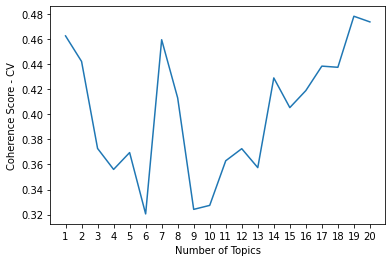

<Figure size 432x288 with 0 Axes>

In [57]:
# plot for cv
# > 0.5 = fairly good 
plt.plot(topics, score_cv)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score - CV')
plt.xticks(topics)
plt.show()
plt.savefig('output/coherence_CV.png')

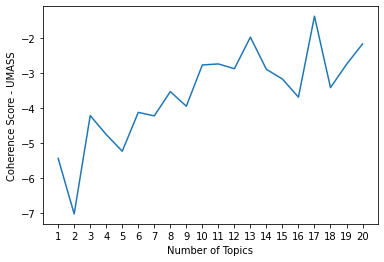

<Figure size 432x288 with 0 Axes>

In [58]:
# plot for umass
# values closer to 0 are better
plt.plot(topics, score_umass)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score - UMASS')
plt.xticks(topics)
plt.show()
plt.savefig('output/coherence_UMASS.png')


### 3.3. LDA

Once and optimal number of topics is defined, we can then see the topics
Here we apply the model again with better parameters (more iterations )

In [59]:
# LdaModel 
# Set training parameters
num_topics = 17
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # not evaluating model perplexity, takes too much time


lda_model = models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    # We set alpha = 'auto' and eta = 'auto'
    # essentially we are automatically learning two parameters in the model that we usually would have to specify explicitly
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)



In [60]:
# see the topics
print("See topics")
pprint(lda_model.print_topics())

# get top topics
top_topics = lda_model.top_topics(corpus)
print("\nSee top topics")
pprint(top_topics)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)



See topics
[(0,
  '0.003*"the" + 0.002*"of" + 0.002*"project" + 0.002*"to" + 0.001*"you" + '
  '0.001*"and" + 0.001*"or" + 0.001*"work" + 0.001*"with" + 0.001*"thi"'),
 (1,
  '0.030*"estacio" + 0.028*"helena" + 0.012*"the" + 0.010*"ursula" + '
  '0.008*"melchior" + 0.007*"of" + 0.006*"mendonça" + 0.006*"camargo" + '
  '0.006*"eugenia" + 0.006*"project"'),
 (2,
  '0.003*"the" + 0.002*"of" + 0.002*"project" + 0.002*"to" + 0.001*"you" + '
  '0.001*"and" + 0.001*"or" + 0.001*"work" + 0.001*"with" + 0.001*"thi"'),
 (3,
  '0.013*"capitú" + 0.008*"the" + 0.005*"of" + 0.004*"escobar" + '
  '0.004*"project" + 0.004*"seminario" + 0.003*"to" + 0.003*"tio" + '
  '0.003*"you" + 0.003*"and"'),
 (4,
  '0.013*"helena" + 0.013*"the" + 0.013*"barão" + 0.009*"cavalcante" + '
  '0.008*"of" + 0.007*"leonor" + 0.007*"cecilia" + 0.006*"project" + '
  '0.006*"leocadia" + 0.006*"carlota"'),
 (5,
  '0.003*"the" + 0.002*"of" + 0.002*"project" + 0.002*"to" + 0.001*"you" + '
  '0.001*"and" + 0.001*"or" + 0.001*"wo

In [61]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim_models.prepare(lda_model, corpus, dicio)




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.057133 -0.033618       1        1  20.487105
3      0.005291  0.022445       2        1  15.399153
13    -0.127345  0.013860       3        1  14.148817
9     -0.041931  0.031669       4        1   9.707253
8      0.122917  0.096067       5        1   9.556976
1     -0.097183  0.008629       6        1   9.258642
10     0.097700  0.044800       7        1   8.291092
4     -0.070198 -0.016283       8        1   7.994245
14     0.098318 -0.155976       9        1   5.156010
7      0.008764 -0.001551      10        1   0.000094
12     0.008657 -0.001411      11        1   0.000092
16     0.008520 -0.001429      12        1   0.000090
6      0.008677 -0.001435      13        1   0.000088
2      0.008713 -0.001432      14        1   0.000087
5      0.008733 -0.001452      15        1   0.000087
15     0.008766 -0.001439      16        1   0.000084
0      0.008735 -0.001445      17        1   0.000084, topic_info=            Term         Freq        Total Category  logprob  loglift
9961         the  1272.000000  1272.000000  Default  30.0000  30.0000
9024          of   762.000000   762.000000  Default  29.0000  29.0000
9364     project   606.000000   606.000000  Default  28.0000  28.0000
9988          to   557.000000   557.000000  Default  27.0000  27.0000
10243        you   511.000000   511.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
9951       terms     0.000058   151.243187  Topic17  -7.5670  -0.7722
8647          is     0.000053   135.779567  Topic17  -7.6564  -0.7538
8223      fallar     0.000060   192.392190  Topic17  -7.5415  -0.9873
7635   copyright     0.000053   136.164198  Topic17  -7.6710  -0.7712
7058   agreement     0.000052   128.145251  Topic17  -7.6890  -0.7286

[1477 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17071      7  0.754434    abanei
3116       1  0.098097  accordar
3116       2  0.117716  accordar
3116       3  0.176575  accordar
3116       4  0.039239  accordar
...      ...       ...       ...
3055       1  0.687896         ó
3055       2  0.042994         ó
3055       5  0.171974         ó
3055       6  0.021497         ó
3055       9  0.042994         ó

[1853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 4, 14, 10, 9, 2, 11, 5, 15, 8, 13, 17, 7, 3, 6, 16, 1])

In [52]:

# prepare visualization
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dicio)
#pyLDAvis.display(lda_display) # TODO check this: visualizacao - nao funciona no colab
# save as html
pyLDAvis.save_html(lda_display, 'output/lda_vis.html')

### 3.4. LSI

Latent Semantic Indexing, LSI (or sometimes LSA) transforms documents 
from either bag-of-words or (preferrably) TfIdf-weighted space 
into a latent space of a lower dimensionality. 



In [62]:
# initialize a model
tfidf = models.TfidfModel(corpus)  
corpus_tfidf = tfidf[corpus]

# then we apply the model
lsi_model_bow = models.LsiModel(corpus, id2word=dicio, num_topics=17)
print('topics using bag of words')
pprint(lsi_model_bow.print_topics())

lsi_model_tfidf = models.LsiModel(corpus_tfidf, id2word=dicio, num_topics=17)
print('topics using tfidf-weighted space')
pprint(lsi_model_tfidf.print_topics())

topics using bag of words
[(0,
  '0.449*"the" + 0.290*"helena" + 0.267*"of" + 0.244*"estacio" + 0.235*"jorge" '
  '+ 0.213*"project" + 0.195*"to" + 0.180*"you" + 0.160*"and" + 0.149*"yayá"'),
 (1,
  '0.771*"rubião" + 0.377*"sophia" + 0.244*"maria" + 0.175*"palha" + '
  '0.122*"fallar" + 0.121*"carlos" + 0.114*"benedicta" + 0.111*"quincas" + '
  '0.107*"borba" + 0.102*"fernanda"'),
 (2,
  '0.451*"helena" + -0.444*"jorge" + 0.443*"estacio" + -0.299*"yayá" + '
  '-0.297*"estella" + -0.215*"luiz" + -0.197*"garcia" + 0.145*"ursula" + '
  '0.116*"melchior" + -0.096*"valeria"'),
 (3,
  '-0.362*"estacio" + -0.336*"jorge" + -0.278*"helena" + -0.255*"estella" + '
  '-0.254*"yayá" + 0.224*"the" + 0.180*"flora" + 0.174*"ayres" + '
  '-0.168*"garcia" + 0.161*"pedro"'),
 (4,
  '-0.331*"tristão" + -0.330*"fidelia" + -0.279*"aguiar" + -0.263*"carmo" + '
  '-0.257*"capitú" + 0.247*"guiomar" + -0.201*"rita" + -0.157*"flora" + '
  '-0.157*"ayres" + -0.148*"pedro"'),
 (5,
  '0.302*"guiomar" + -0.290*"flor